# Скачивание и импорт библиотек

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os
import time
import gc

import tensorflow as tf
from keras import backend as K
import keras

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape


# Скачивание и создание датасета

In [ ]:
# @title Скачиваю датасет
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# @title Изменяю размерность
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
print(X_train.shape)
X_train = (X_train - 127.5) / 127.5

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
# Размерность случайного шума
LATENT_DIM = 100
# Инициализация весов для G
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Количество каналов
CHANNELS = 1
img_shape=(28,28)
BATCH_SIZE=32

dataset=tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE)

# Рисунки датасета

<ipython-input-5-4a6364a677d8>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


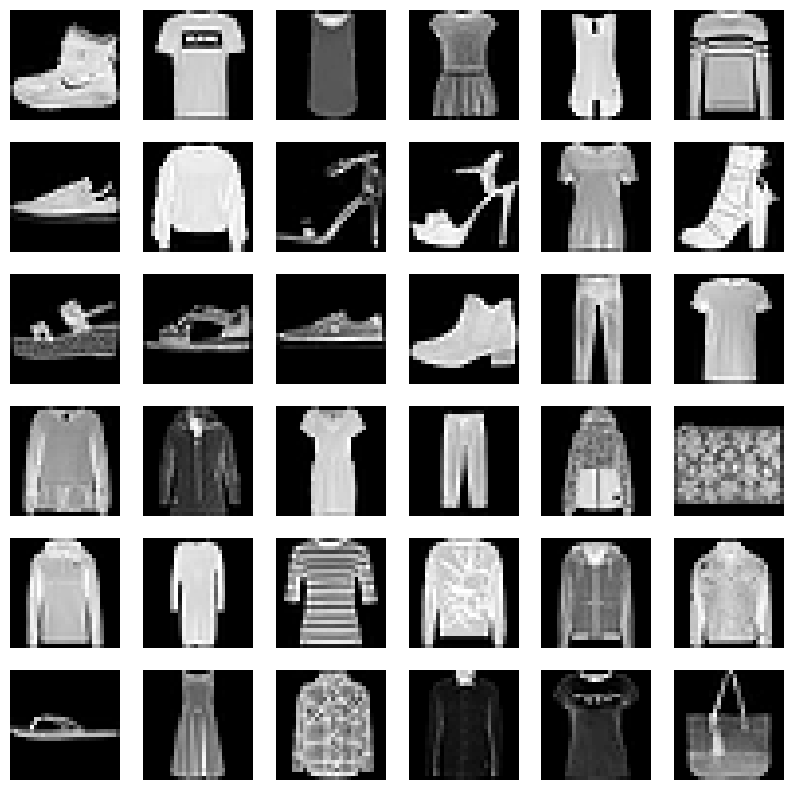

In [ ]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Реальные изображения", fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(X_train[i]*0.5 + 0.5, cmap='gray')
        plt.axis('off')

# to plot images
plot_images(6)

# Вспомогательные функции

In [ ]:
# @title Функция тренировки
import time

def train(epochs, dataset, generator, discriminator, train_steps):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images, generator, discriminator)
        print(" Время:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'],loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [ ]:
# Этот метод возвращает вспомогательную функцию для вычисления перекрестных потерь энтропии
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(fake_output, real_output):
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  return fake_loss + real_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def plot_generated_images(generator, square = 5):
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

    plt.axis('off')
    plt.grid()

In [ ]:
def loss_plot(G, D):
  plt.figure(figsize=(10,10))
  plt.plot(G,color='red',label='Функция потерь на генераторе')
  plt.plot(D,color='blue',label='Функция потерь на дискриминаторе')
  plt.legend()
  plt.xlabel('Эпоха')
  plt.ylabel('Потери')
  plt.title('Функции потерь в конце обучения на эпохе')
  plt.show()

# Архитектура модели Классического GAN

In [ ]:
# @title Создаем генератор
def Classic_Generator():
  model = Sequential(name='Classic_Generator')

  model.add(Dense(256, input_dim=LATENT_DIM))
  # Не плотный вариант линейного слоя
  model.add(LeakyReLU(alpha=0.2))
  # Момент для скользящего среднего и скользящей дисперсии
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))

  return model

In [ ]:
# @title Инициализация классического генератора
Classic_G = Classic_Generator()
Classic_G.summary()

NameError: name 'Classic_Generator' is not defined

In [ ]:
# @title Создаем дискриминатор
def Classic_Discriminator():
  model = Sequential(name='Classic_Discriminator')
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
# @title Инициализация дискриминатора
Classic_D = Classic_Discriminator()
Classic_D.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Classic_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer_G = tf.keras.optimizers.Adam(.0002, 0.5)
optimizer_D = tf.keras.optimizers.Adam(.0002, 0.5)

In [ ]:
# Мы используем декоратор `tf.function`, можно и без него
# Он указывает на то, что функция должна быть скомпилирована, что оптимизирует процесс обучения.
@tf.function
def train_steps1(images, generator, discriminator):

    # генерируем шум на входе генератора
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Инициализируем GradientTape (градиентную ленту) для дискриминатора и генератор
    #  по отдельности, чтобы записать операции,
    # выполняемые во время прямого прохода, включающего автодифференцирование.
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        # Запустим прямой проход шума через генератор.
        # Операции применяемые каждым слоем к своим
        # входным данным будут записаны на GradientTape, как на ленту магнитофона.
        # Отсюда и название градиентной ленты.
        generated_images = generator(noise)

        # Также обеспечиваем прямой проход через дискриминатор для
        # для реальных и фейковых изображений
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        # расчитываем функции ошибок (значения потерь)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Используем gradient tape для автоматического извлечения градиентов
    # обучаемых переменных относительно потерь.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Выполним один шаг градиентного спуска, обновив
    # значение переменных минимизирующих потери.
    optimizer_G.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    # Вернем значения потерь для визуализации
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

# Тренировка GAN

In [ ]:
G, D = train(1000, dataset, Classic_G, Classic_D, train_steps1)


Эпоха : 1
 Время:41.0
Generator Loss: 0.817295253276825 Discriminator Loss: 1.3084949254989624

Эпоха : 2
 Время:10.0
Generator Loss: 0.8165337443351746 Discriminator Loss: 1.2932379245758057

Эпоха : 3
 Время:10.0
Generator Loss: 0.9692903757095337 Discriminator Loss: 1.3656909465789795

Эпоха : 4
 Время:20.0
Generator Loss: 0.8488729000091553 Discriminator Loss: 1.3590660095214844

Эпоха : 5
 Время:10.0
Generator Loss: 0.802024245262146 Discriminator Loss: 1.305579662322998

Эпоха : 6
 Время:9.0
Generator Loss: 0.8671521544456482 Discriminator Loss: 1.3070265054702759

Эпоха : 7
 Время:10.0
Generator Loss: 0.7406004667282104 Discriminator Loss: 1.3960295915603638

Эпоха : 8
 Время:10.0
Generator Loss: 0.770829439163208 Discriminator Loss: 1.394126057624817

Эпоха : 9
 Время:10.0
Generator Loss: 0.7902908325195312 Discriminator Loss: 1.3067587614059448

Эпоха : 10
 Время:9.0
Generator Loss: 0.7241424322128296 Discriminator Loss: 1.4014211893081665

Эпоха : 11
 Время:10.0
Generator Lo

# Итог GAN

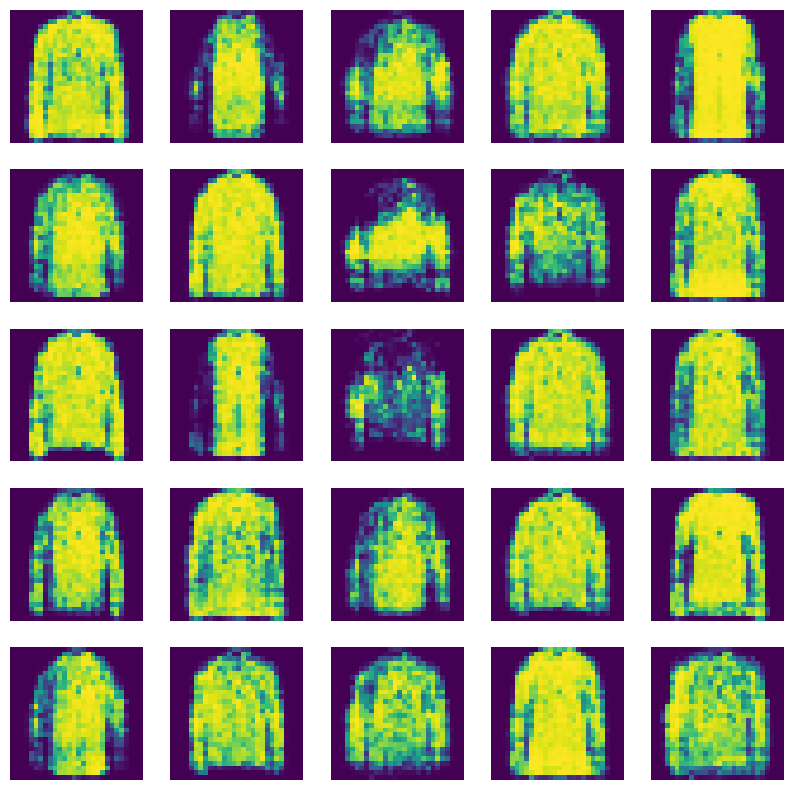

In [ ]:
plot_generated_images(Classic_G, 5)

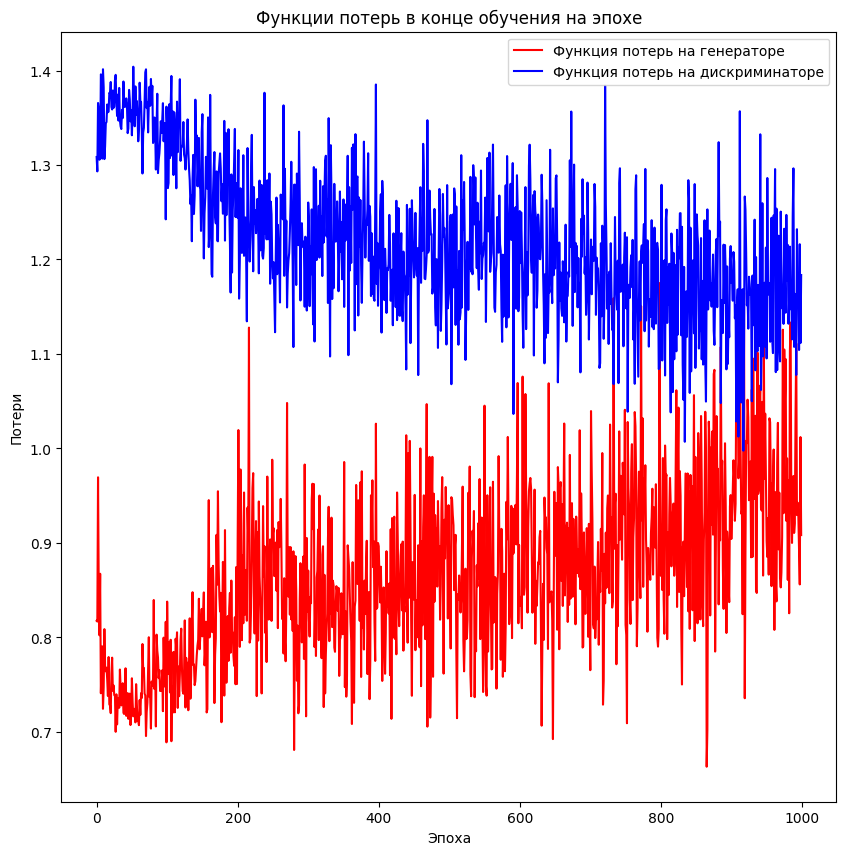

In [ ]:
loss_plot(G, D)

# Архитектура модели DCGAN

In [ ]:
# @title Создаем Генератор
def Generator():
    model = Sequential(name="generator")

    # Подаем случайный шум на вход генератору
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Изменяем форму слоя 1D в 3D
    model.add(layers.Reshape((7, 7, 256)))

    # Повышаем дискретизацию (14*14)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # Повышаем дискретизацию (28*28)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    return model

In [ ]:
# @title Инициализация Генератора
generator = Generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,343,681 (8.94 MB)

 Trainable params: 2,318,209 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [ ]:
# @title Дискриминатор
def Discriminator(width, height, depth, alpha=0.2):
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # Понижаем дискретизацию
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [ ]:
# @title Инициализация Дискриминатора
discriminator = Discriminator(28,28,1)
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,633 (834.50 KB)

 Trainable params: 213,249 (833.00 KB)

 Non-trainable params: 384 (1.50 KB)

# Тренировка DСGAN

In [ ]:
# Мы используем декоратор `tf.function`, можно и без него
# Он указывает на то, что функция должна быть скомпилирована, что оптимизирует процесс обучения.
@tf.function
def train_steps2(images, generator, discriminator):

    # генерируем шум на входе генератора
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Инициализируем GradientTape (градиентную ленту) для дискриминатора и генератор
    #  по отдельности, чтобы записать операции,
    # выполняемые во время прямого прохода, включающего автодифференцирование.
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        # Запустим прямой проход шума через генератор.
        # Операции применяемые каждым слоем к своим
        # входным данным будут записаны на GradientTape, как на ленту магнитофона.
        # Отсюда и название градиентной ленты.
        generated_images = generator(noise)

        # Также обеспечиваем прямой проход через дискриминатор для
        # для реальных и фейковых изображений
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        # расчитываем функции ошибок (значения потерь)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Используем gradient tape для автоматического извлечения градиентов
    # обучаемых переменных относительно потерь.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Выполним один шаг градиентного спуска, обновив
    # значение переменных минимизирующих потери.
    optimizer_G.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    # Вернем значения потерь для визуализации
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

In [ ]:
optimizer_G = tf.keras.optimizers.RMSprop(learning_rate=.0001)
optimizer_D = tf.keras.optimizers.RMSprop(learning_rate=.0001)
G, D = train(75, dataset, generator, discriminator, train_steps2)


Эпоха : 1
 Время:29.0
Generator Loss: 0.725652277469635 Discriminator Loss: 1.3650257587432861

Эпоха : 2
 Время:24.0
Generator Loss: 0.7719306945800781 Discriminator Loss: 1.3432068824768066

Эпоха : 3
 Время:24.0
Generator Loss: 0.6871523857116699 Discriminator Loss: 1.406262993812561

Эпоха : 4
 Время:26.0
Generator Loss: 0.7592034339904785 Discriminator Loss: 1.297623872756958

Эпоха : 5
 Время:25.0
Generator Loss: 0.7342125177383423 Discriminator Loss: 1.3605355024337769

Эпоха : 6
 Время:25.0
Generator Loss: 0.6948060989379883 Discriminator Loss: 1.4076690673828125

Эпоха : 7
 Время:25.0
Generator Loss: 0.7975925803184509 Discriminator Loss: 1.283682107925415

Эпоха : 8
 Время:25.0
Generator Loss: 0.7616618871688843 Discriminator Loss: 1.3224107027053833

Эпоха : 9
 Время:25.0
Generator Loss: 0.7674187421798706 Discriminator Loss: 1.333771824836731

Эпоха : 10
 Время:25.0
Generator Loss: 0.7570914030075073 Discriminator Loss: 1.3357694149017334

Эпоха : 11
 Время:25.0
Generator 

# Итоги DCGAN

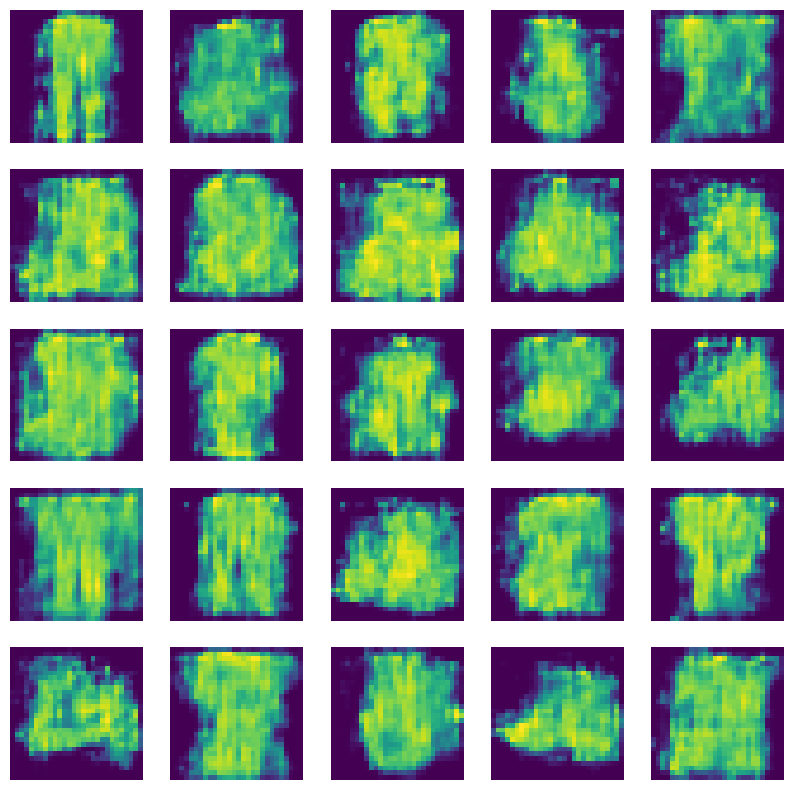

In [ ]:
plot_generated_images(generator,5)

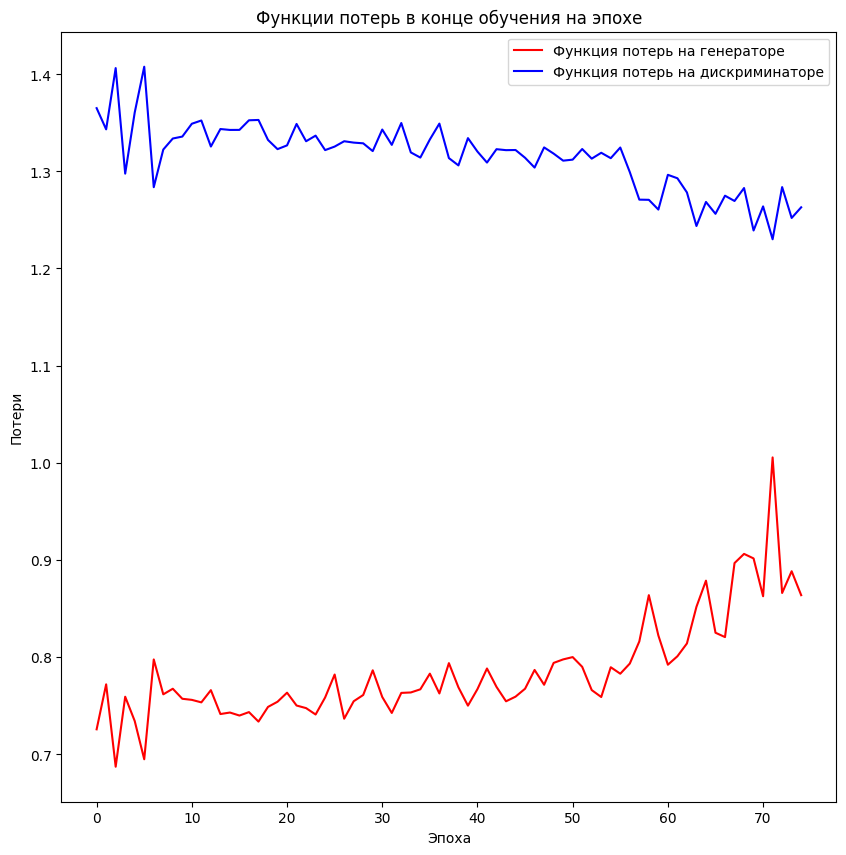

In [ ]:
loss_plot(G, D)

# Выводы

### При обучении обычного GAN используется обычные слои Dense.
### Для хорошего обучения модели необходимо использовать больше тысячи эпох.
### При обучении DGAN используется сверточная сеть.
### Для её обучения требуется намного меньше эпох, но отличный результат получается не сразу ( сеть не постоянна)
